In [1]:
%pip install scikit-learn pandas matplotlib imbalanced-learn tensorflow


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from scipy import stats

In [3]:
DATA_PATH = "letter-recognition.data"
HEADERS = [
    "lettr",
    "x-box",
    "y-box",
    "width",
    "high",
    "onpix",
    "x-bar",
    "y-bar",
    "x2bar",
    "y2bar",
    "xybar",
    "x2ybr",
    "xy2br",
    "x-ege",
    "xegvy",
    "y-ege",
    "yegvx",
]

In [4]:
data = pd.read_csv(DATA_PATH, header=None, names=HEADERS)

In [5]:
data.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


# Preprocessing

In [6]:
data.shape

(20000, 17)

<BarContainer object of 26 artists>

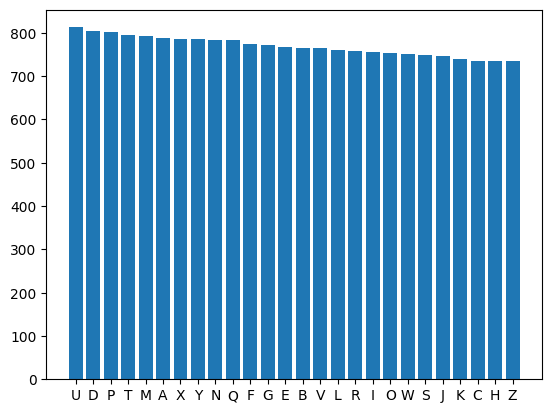

In [7]:
plt.bar(data["lettr"].value_counts().index, data["lettr"].value_counts().values)

In [8]:
# print max and min count of a letter
max_count = data["lettr"].value_counts().max()
min_count = data["lettr"].value_counts().min()
# print how many % more is the max than the min
print(max_count)
print(min_count)
print(f"Max is {(1 - max_count / min_count) * (-1) * 100} more than min")

813
734
Max is 10.762942779291551 more than min


In [9]:
# remove duplicates
data.drop_duplicates(inplace=True)

In [10]:
data.shape

(18668, 17)

<BarContainer object of 26 artists>

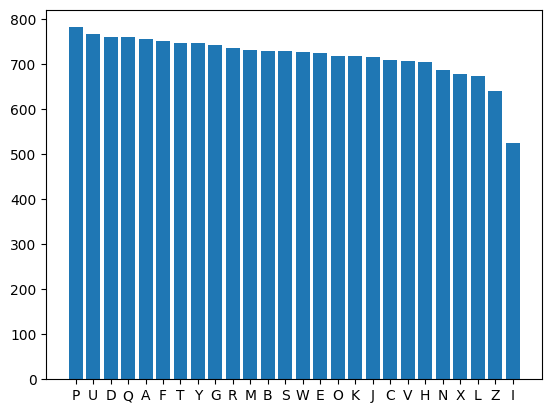

In [11]:
plt.bar(data["lettr"].value_counts().index, data["lettr"].value_counts().values)

In [12]:
# remove outliers
z_scores = stats.zscore(data[HEADERS[1:]])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]

In [13]:
data.shape

(17257, 17)

<BarContainer object of 26 artists>

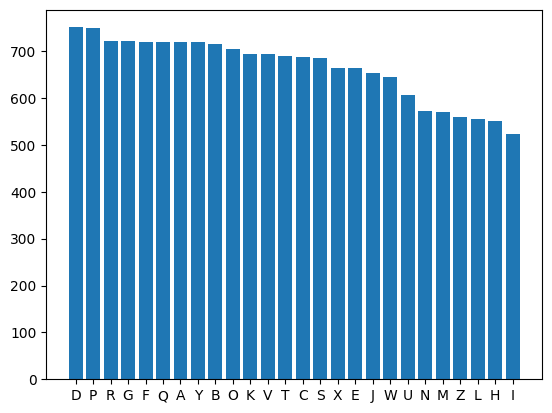

In [14]:
plt.bar(data["lettr"].value_counts().index, data["lettr"].value_counts().values)

In [15]:
# print max and min count of a letter
max_count = data["lettr"].value_counts().max()
min_count = data["lettr"].value_counts().min()
# print how many % more is the max than the min
print(max_count)
print(min_count)
print(f"Max is {(1 - max_count / min_count) * (-1) * 100} more than min")

751
523
Max is 43.594646271510506 more than min


In [16]:
# Under sampling
rus = RandomUnderSampler(random_state=42)
under_sample, under_sample_labels = rus.fit_resample(data[HEADERS[1:]], data[HEADERS[0]])

In [17]:
under_sample.shape

(13598, 16)

<BarContainer object of 26 artists>

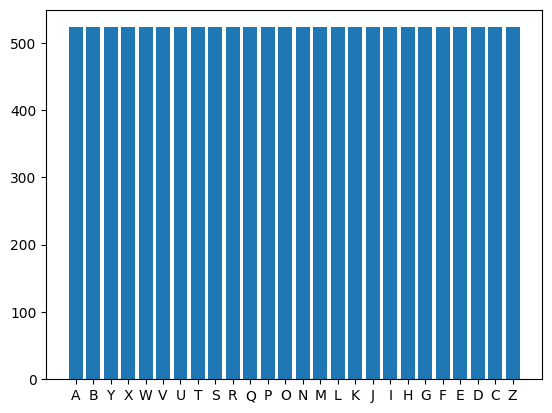

In [18]:
plt.bar(
    pd.Series(under_sample_labels).value_counts().index,
    pd.Series(under_sample_labels).value_counts().values,
)

In [19]:
# Over sampling
ros = RandomOverSampler(random_state=42)
over_sample, over_sample_labels = ros.fit_resample(data[HEADERS[1:]], data[HEADERS[0]])

In [20]:
over_sample.shape

(19526, 16)

<BarContainer object of 26 artists>

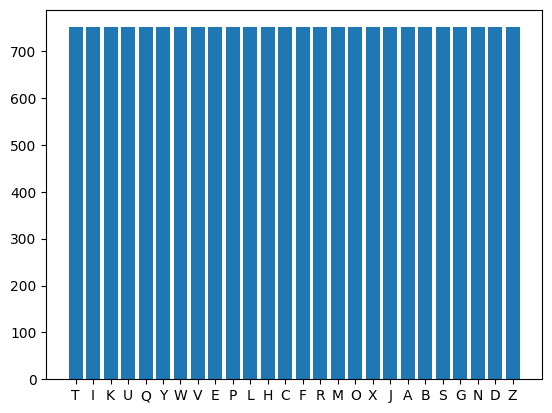

In [21]:
plt.bar(
    pd.Series(over_sample_labels).value_counts().index,
    pd.Series(over_sample_labels).value_counts().values,
)

In [22]:
data["lettr"] = data["lettr"].apply(lambda x: ord(x) - 65)
over_sample_labels = over_sample_labels.apply(lambda x: ord(x) - 65)
under_sample_labels = under_sample_labels.apply(lambda x: ord(x) - 65)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    data[HEADERS[1:]], data[HEADERS[0]], test_size=0.20, random_state=42
)
x_train_under, x_test_under, y_train_under, y_test_under = train_test_split(
    under_sample, under_sample_labels, test_size=0.20, random_state=42
)
x_train_over, x_test_over, y_train_over, y_test_over = train_test_split(
    over_sample, over_sample_labels, test_size=0.20, random_state=42
)
print(x_train_over.shape, x_test_over.shape, y_train_over.shape, y_test_over.shape)
print(x_train_under.shape, x_test_under.shape, y_train_under.shape, y_test_under.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(15620, 16) (3906, 16) (15620,) (3906,)
(10878, 16) (2720, 16) (10878,) (2720,)
(13805, 16) (3452, 16) (13805,) (3452,)


In [24]:
x_train = normalize(x_train)
x_test = normalize(x_test)
x_train_under = normalize(x_train_under)
x_test_under = normalize(x_test_under)
x_train_over = normalize(x_train_over)
x_test_over = normalize(x_test_over)

In [25]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(26, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    x_train,
    y_train,
    epochs=40,
)

Epoch 1/40
432/432 [==============================] - 0s 800us/step - loss: 2.2145 - accuracy: 0.3985
Epoch 2/40
432/432 [==============================] - 0s 628us/step - loss: 1.3627 - accuracy: 0.6142
Epoch 3/40
432/432 [==============================] - 0s 621us/step - loss: 1.1555 - accuracy: 0.6740
Epoch 4/40
432/432 [==============================] - 0s 659us/step - loss: 1.0463 - accuracy: 0.7041
Epoch 5/40
432/432 [==============================] - 0s 598us/step - loss: 0.9702 - accuracy: 0.7216
Epoch 6/40
432/432 [==============================] - 0s 599us/step - loss: 0.9123 - accuracy: 0.7392
Epoch 7/40
432/432 [==============================] - 0s 596us/step - loss: 0.8596 - accuracy: 0.7528
Epoch 8/40
432/432 [==============================] - 0s 595us/step - loss: 0.8084 - accuracy: 0.7665
Epoch 9/40
432/432 [==============================] - 0s 599us/step - loss: 0.7580 - accuracy: 0.7759
Epoch 10/40
432/432 [==============================] - 0s 594us/step - loss: 0.715

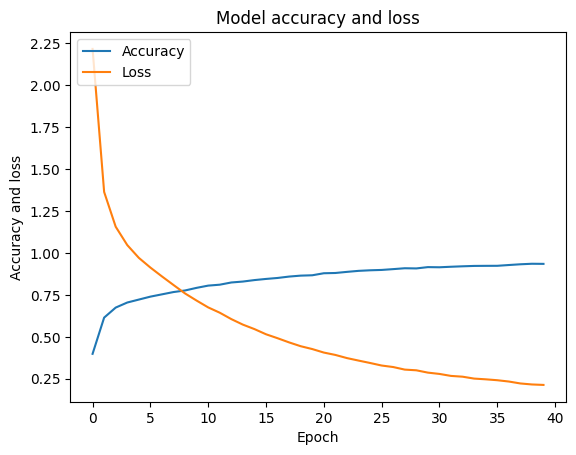

In [26]:
# draw a line graph of accuracy and loss over epochs
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Model accuracy and loss")
plt.ylabel("Accuracy and loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Loss"], loc="upper left")
plt.show()

In [27]:
print(f"Accuracy: {accuracy_score(y_test, np.argmax(model.predict(x_test), axis=1))}")
print(f"F1: {f1_score(y_test, np.argmax(model.predict(x_test), axis=1), average='macro')}")

108/108 [==============================] - 0s 383us/step
Accuracy: 0.9200463499420626
108/108 [==============================] - 0s 351us/step
F1: 0.92002652829646


In [28]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(26, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    x_train_over,
    y_train_over,
    epochs=40,
)

Epoch 1/40
489/489 [==============================] - 0s 618us/step - loss: 2.1685 - accuracy: 0.4125
Epoch 2/40
489/489 [==============================] - 0s 688us/step - loss: 1.2998 - accuracy: 0.6288
Epoch 3/40
489/489 [==============================] - 0s 629us/step - loss: 1.1167 - accuracy: 0.6825
Epoch 4/40
489/489 [==============================] - 0s 633us/step - loss: 1.0117 - accuracy: 0.7117
Epoch 5/40
489/489 [==============================] - 0s 628us/step - loss: 0.9340 - accuracy: 0.7360
Epoch 6/40
489/489 [==============================] - 0s 628us/step - loss: 0.8667 - accuracy: 0.7526
Epoch 7/40
489/489 [==============================] - 0s 639us/step - loss: 0.8105 - accuracy: 0.7679
Epoch 8/40
489/489 [==============================] - 0s 637us/step - loss: 0.7596 - accuracy: 0.7834
Epoch 9/40
489/489 [==============================] - 0s 654us/step - loss: 0.7172 - accuracy: 0.7928
Epoch 10/40
489/489 [==============================] - 0s 767us/step - loss: 0.674

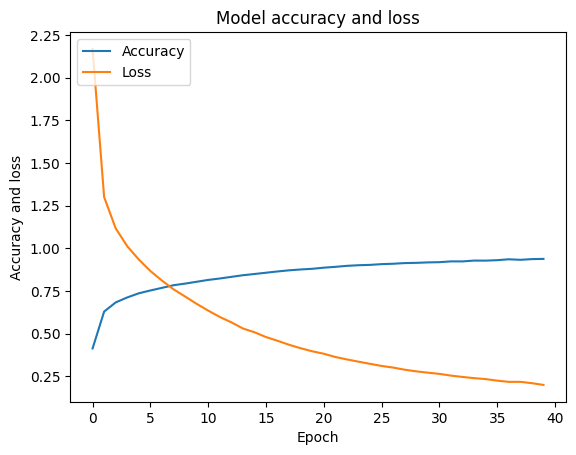

In [29]:
# draw a line graph of accuracy and loss over epochs
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Model accuracy and loss")
plt.ylabel("Accuracy and loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Loss"], loc="upper left")
plt.show()

In [30]:
print(
    f"Accuracy: {accuracy_score(y_test_over, np.argmax(model.predict(x_test_over), axis=1))}"
)
print(
    f"F1: {f1_score(y_test_over, np.argmax(model.predict(x_test_over), axis=1), average='macro')}"
)

123/123 [==============================] - 0s 385us/step
Accuracy: 0.9242191500256016
123/123 [==============================] - 0s 364us/step
F1: 0.9236171067294132


In [31]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(26, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    x_train_under,
    y_train_under,
    epochs=40,
)

Epoch 1/40
340/340 [==============================] - 0s 649us/step - loss: 2.4040 - accuracy: 0.3498
Epoch 2/40
340/340 [==============================] - 0s 645us/step - loss: 1.4991 - accuracy: 0.5820
Epoch 3/40
340/340 [==============================] - 0s 720us/step - loss: 1.2544 - accuracy: 0.6435
Epoch 4/40
340/340 [==============================] - 0s 627us/step - loss: 1.1415 - accuracy: 0.6771
Epoch 5/40
340/340 [==============================] - 0s 624us/step - loss: 1.0639 - accuracy: 0.6995
Epoch 6/40
340/340 [==============================] - 0s 622us/step - loss: 1.0058 - accuracy: 0.7159
Epoch 7/40
340/340 [==============================] - 0s 783us/step - loss: 0.9544 - accuracy: 0.7306
Epoch 8/40
340/340 [==============================] - 0s 807us/step - loss: 0.9118 - accuracy: 0.7372
Epoch 9/40
340/340 [==============================] - 0s 882us/step - loss: 0.8681 - accuracy: 0.7523
Epoch 10/40
340/340 [==============================] - 0s 634us/step - loss: 0.828

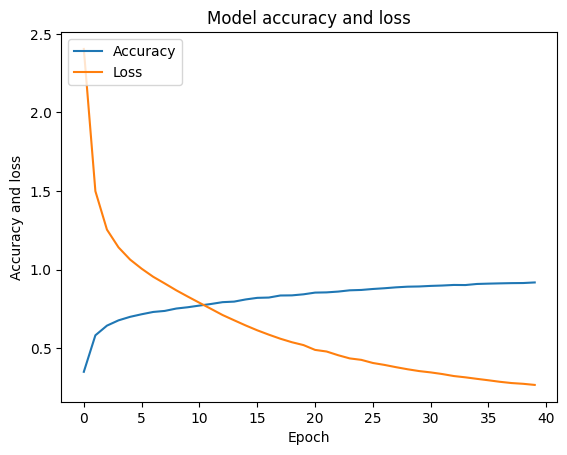

In [32]:
# draw a line graph of accuracy and loss over epochs
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Model accuracy and loss")
plt.ylabel("Accuracy and loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Loss"], loc="upper left")
plt.show()

In [33]:
print(
    f"Accuracy: {accuracy_score(y_test_under, np.argmax(model.predict(x_test_under), axis=1))}"
)
print(
    f"F1: {f1_score(y_test_under, np.argmax(model.predict(x_test_under), axis=1), average='macro')}"
)

85/85 [==============================] - 0s 394us/step
Accuracy: 0.9077205882352941
85/85 [==============================] - 0s 394us/step
F1: 0.9079903112081251


In [34]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [35]:
y_pred = knn.predict(x_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred, average="macro"))

Accuracy score:  0.9426419466975666
F1 score:  0.9429268862393503


In [36]:
knn.fit(x_train_under, y_train_under)

KNeighborsClassifier()

In [37]:
y_pred = knn.predict(x_test_under)
print("Accuracy score: ", accuracy_score(y_test_under, y_pred))
print("F1 score: ", f1_score(y_test_under, y_pred, average="macro"))

Accuracy score:  0.9345588235294118
F1 score:  0.9347468892840806


In [38]:
knn.fit(x_train_over, y_train_over)

KNeighborsClassifier()

In [39]:
y_pred = knn.predict(x_test_over)
print("Accuracy score: ", accuracy_score(y_test_over, y_pred))
print("F1 score: ", f1_score(y_test_over, y_pred, average="macro"))

Accuracy score:  0.9485407066052227
F1 score:  0.947777013009272


In [40]:
param_grid = {"n_neighbors": [3, 5, 7, 9, 11, 13, 15]}
grid = GridSearchCV(knn, param_grid, n_jobs=-1)
grid.fit(x_train, y_train)
grid.best_params_

{'n_neighbors': 3}

In [41]:
grid.fit(x_train_under, y_train_under)
grid.best_params_

{'n_neighbors': 3}

In [42]:
grid.fit(x_train_over, y_train_over)
grid.best_params_

{'n_neighbors': 3}